In [1]:
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
)

from prettytable import PrettyTable

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

In [3]:
sns.set_style("whitegrid")
sns.set_palette("husl")

In [4]:
try:
    nltk.data.find("tokenizers/punkt_tab")
    nltk.data.find("corpora/stopwords")
except LookupError:
    print("📥 Descargando recursos de NLTK...")
    nltk.download("punkt", quiet=True)
    nltk.download("punkt_tab", quiet=True)
    nltk.download("stopwords", quiet=True)
    print("✅ Recursos descargados")


spanish_stopwords = set(stopwords.words("spanish"))
print(f"📚 Stopwords en español cargadas: {len(spanish_stopwords)} palabras")

📥 Descargando recursos de NLTK...
✅ Recursos descargados
📚 Stopwords en español cargadas: 313 palabras


In [5]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [6]:
def data_info(train_df: pd.DataFrame, test_df: pd.DataFrame) -> None:
    info_table = PrettyTable()
    info_table.field_names = ["Métrica", "Entrenamiento", "Prueba"]
    info_table.add_row(["Número de filas", train_df.shape[0], test_df.shape[0]])
    info_table.add_row(["Número de columnas", train_df.shape[1], test_df.shape[1]])
    info_table.add_row(
        ["Valores nulos", train_df.isnull().values.sum(), test_df.isnull().values.sum()]
    )

    print("📊 Información de los datos:")
    print(info_table)

    print("\n🔍 Primeras filas del conjunto de entrenamiento:")
    display(train_df.head())

    print("\n🔍 Primeras filas del conjunto de prueba:")
    display(test_df.head())

In [7]:
data_info(train, test)

📊 Información de los datos:
+--------------------+---------------+--------+
|      Métrica       | Entrenamiento | Prueba |
+--------------------+---------------+--------+
|  Número de filas   |      2424     |  152   |
| Número de columnas |       2       |   1    |
|   Valores nulos    |       0       |   0    |
+--------------------+---------------+--------+

🔍 Primeras filas del conjunto de entrenamiento:


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3



🔍 Primeras filas del conjunto de prueba:


,Textos_espanol
0,"El rector, que es el representante local del M..."
1,Tenga en cuenta que todos los programas antipo...
2,"Debido a que son en gran medida invisibles, es..."
3,Los recursos aún son limitados en este sector....
4,"Durante el período 1985-2008, la educación pri..."


In [8]:
class_counts = train["labels"].value_counts().sort_index()

In [9]:
def balance_analysis(data: pd.Series):
    _, (bar_abs, pie_p) = plt.subplots(1, 2, figsize=(15, 6))

    sns.barplot(
        x=data.index,
        y=data.values,
        hue=data.index,
        ax=bar_abs,
        palette="Set2",
        legend=False,
    )
    bar_abs.set_title("Distribución de Clases (ODS)", fontsize=14, fontweight="bold")
    bar_abs.set_xlabel("ODS (Objetivos de Desarrollo Sostenible)")
    bar_abs.set_ylabel("Número de Textos")

    bar_abs.set_xticks(range(len(data.index)))
    bar_abs.set_xticklabels(
        ["ODS 1\n(Pobreza)", "ODS 3\n(Salud)", "ODS 4\n(Educación)"]
    )

    colors = sns.color_palette("Set2", len(data))
    _, _, autotexts = pie_p.pie(
        data.values,
        labels=["ODS 1", "ODS 3", "ODS 4"],
        autopct="%1.1f%%",
        colors=colors,
        explode=(0.05, 0.05, 0.05),
    )
    pie_p.set_title("Proporción de Clases", fontsize=14, fontweight="bold")

    for autotext in autotexts:
        autotext.set_color("white")
        autotext.set_fontweight("bold")

    plt.tight_layout()
    plt.show()

    max_class = class_counts.max()
    min_class = class_counts.min()
    balance_ratio = max_class / min_class
    print(
        f"\n Ratio de desbalance: {balance_ratio:.2f} (clase más frecuente / clase menos frecuente)"
    )
    if balance_ratio > 2:
        print(
            "⚠️  Dataset moderadamente desbalanceado - considerar técnicas de balanceo"
        )
    else:
        print("✅ Dataset relativamente balanceado")

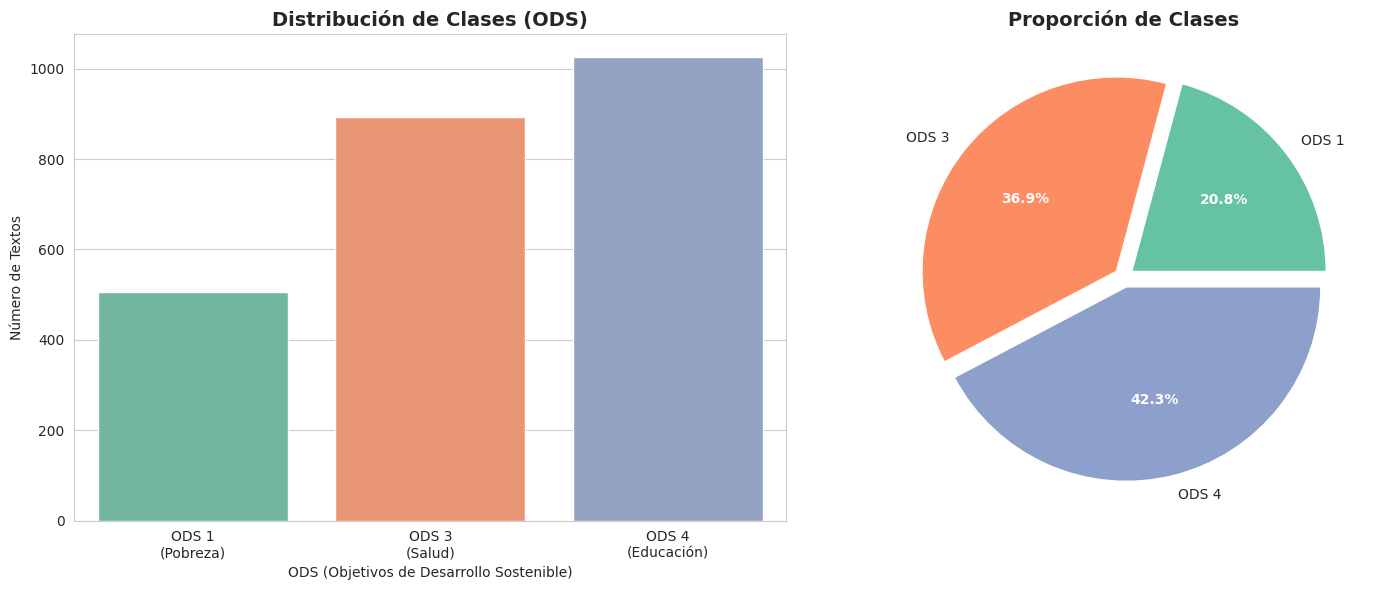


 Ratio de desbalance: 2.03 (clase más frecuente / clase menos frecuente)
⚠️  Dataset moderadamente desbalanceado - considerar técnicas de balanceo


In [10]:
balance_analysis(class_counts)

In [11]:
def clean_text(text: str) -> str:
    """
    Limpia y normaliza texto en español.
    """
    if pd.isna(text):
        return ""

    # Convertir a minúsculas
    text = text.lower()

    # Eliminar comillas y caracteres especiales al inicio/final
    text = text.strip("\"'")

    # Mantener solo letras, números y espacios
    text = re.sub(r"[^\w\s]", " ", text)

    # Eliminar espacios múltiples
    text = re.sub(r"\s+", " ", text)

    # Tokenizar y eliminar stopwords
    tokens = word_tokenize(text, language="spanish")
    tokens = [
        token for token in tokens if token not in spanish_stopwords and len(token) > 2
    ]

    return " ".join(tokens)


def analyze_text_length(df: pd.DataFrame, text_column: str) -> None:
    df_copy = df.copy()
    df_copy["text_length"] = df_copy[text_column].str.len()
    df_copy["word_count"] = df_copy[text_column].str.split().str.len()

    _, (text_f, char_f) = plt.subplots(1, 2, figsize=(15, 5))

    sns.histplot(
        data=df_copy,
        x="text_length",
        bins=50,
        ax=text_f,
        color="skyblue",
        alpha=0.7,
        kde=True,
    )
    text_f.set_title(
        "Distribución de Longitud de Texto (caracteres)", fontsize=12, fontweight="bold"
    )
    text_f.set_xlabel("Número de Caracteres")
    text_f.set_ylabel("Frecuencia")

    sns.histplot(
        data=df_copy,
        x="word_count",
        bins=50,
        ax=char_f,
        color="lightcoral",
        alpha=0.7,
        kde=True,
    )
    char_f.set_title(
        "Distribución de Número de Palabras", fontsize=12, fontweight="bold"
    )
    char_f.set_xlabel("Número de Palabras")
    char_f.set_ylabel("Frecuencia")

    plt.tight_layout()
    plt.show()

    print("📊 Estadísticas de longitud de texto:")
    print(f"   • Promedio de caracteres: {df_copy['text_length'].mean():.1f}")
    print(f"   • Promedio de palabras: {df_copy['word_count'].mean():.1f}")
    print(f"   • Mediana de palabras: {df_copy['word_count'].median():.1f}")

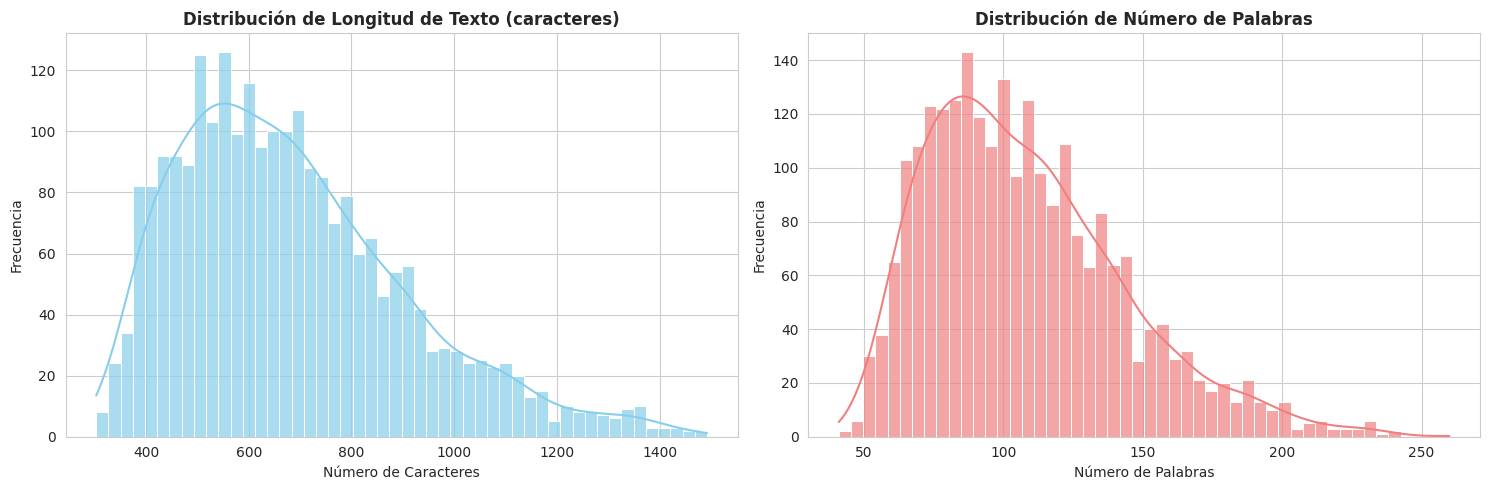

📊 Estadísticas de longitud de texto:
   • Promedio de caracteres: 683.2
   • Promedio de palabras: 107.9
   • Mediana de palabras: 102.0


In [12]:
analyze_text_length(train, "textos")

In [13]:
print("🔧 Preparando datos para modelado...")

train_clean = train.copy()
test_clean = test.copy()

train_clean["textos_clean"] = train_clean["textos"].apply(clean_text)
test_clean["textos_clean"] = test_clean["Textos_espanol"].apply(clean_text)

empty_texts = train_clean["textos_clean"].str.strip().eq("").sum()
print(f"📊 Textos vacíos después de limpieza: {empty_texts}")

if empty_texts > 0:
    mask = train_clean["textos_clean"].str.strip().eq("")
    train_clean.loc[mask, "textos_clean"] = (
        train_clean.loc[mask, "textos"]
        .str.lower()
        .str.replace(r"[^\w\s]", " ", regex=True)
    )

print("✅ Preparación de datos completada")

🔧 Preparando datos para modelado...
📊 Textos vacíos después de limpieza: 0
✅ Preparación de datos completada


In [14]:
print("📊 Dividiendo datos y aplicando vectorización...")

X = train_clean["textos_clean"]
y = train_clean["labels"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Usar unigramas y bigramas
    min_df=2,  # Palabras que aparecen al menos 2 veces
    max_df=0.95,  # Excluir palabras muy comunes
    strip_accents="unicode",  # Normalizar acentos
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

print("✅ Vectorización completada:")
print(f"   • Forma X_train: {X_train_tfidf.shape}")
print(f"   • Forma X_val: {X_val_tfidf.shape}")
print(f"   • Vocabulario: {len(vectorizer.vocabulary_)} palabras")

📊 Dividiendo datos y aplicando vectorización...
✅ Vectorización completada:
   • Forma X_train: (1939, 5000)
   • Forma X_val: (485, 5000)
   • Vocabulario: 5000 palabras


In [15]:
print("🤖 Configurando modelos de Machine Learning...")

models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,
    ),
    "SVM": SVC(
        kernel="linear",
        C=1.0,
        random_state=42,
        probability=True,  # Para obtener probabilidades
    ),
    "Naive Bayes": MultinomialNB(
        alpha=1.0  # Suavizado de Laplace
    ),
    "Logistic Regression": LogisticRegression(
        C=1.0, max_iter=1000, random_state=42, n_jobs=-1
    ),
}

print(f"✅ {len(models)} modelos configurados:")
for name in models.keys():
    print(f"   • {name}")

🤖 Configurando modelos de Machine Learning...
✅ 4 modelos configurados:
   • Random Forest
   • SVM
   • Naive Bayes
   • Logistic Regression


In [16]:
def train_and_evaluate_model(name: str, model, X_train, y_train, X_val, y_val):
    print(f"🔄 Entrenando {name}...")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average="macro")
    f1_micro = f1_score(y_val, y_pred, average="micro")

    report = classification_report(
        y_val, y_pred, target_names=["ODS 1", "ODS 3", "ODS 4"]
    )

    return {
        "model": model,
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "predictions": y_pred,
        "classification_report": report,
    }


print("✅ Función de entrenamiento y evaluación definida")

✅ Función de entrenamiento y evaluación definida


In [17]:
print("🚀 Iniciando entrenamiento de todos los modelos...\n")

model_results = {}
for name, model in models.items():
    results = train_and_evaluate_model(
        name, model, X_train_tfidf, y_train, X_val_tfidf, y_val
    )
    model_results[name] = results
    print(f"✅ {name} completado\n")

print("🏁 Entrenamiento de todos los modelos completado!")

🚀 Iniciando entrenamiento de todos los modelos...

🔄 Entrenando Random Forest...
✅ Random Forest completado

🔄 Entrenando SVM...
✅ SVM completado

🔄 Entrenando Naive Bayes...
✅ Naive Bayes completado

🔄 Entrenando Logistic Regression...
✅ Logistic Regression completado

🏁 Entrenamiento de todos los modelos completado!


In [18]:
print("📊 Comparación de rendimiento de modelos:")
print("=" * 50)

comparison_table = PrettyTable()
comparison_table.field_names = [
    "Modelo",
    "Accuracy",
    "F1-Score (Macro)",
    "F1-Score (Micro)",
]

for name, results in model_results.items():
    comparison_table.add_row(
        [
            name,
            f"{results['accuracy']:.4f}",
            f"{results['f1_macro']:.4f}",
            f"{results['f1_micro']:.4f}",
        ]
    )

print(comparison_table)

best_model_name = max(model_results.items(), key=lambda x: x[1]["f1_macro"])[0]
best_model_results = model_results[best_model_name]

print(f"\n🏆 Mejor modelo: {best_model_name}")
print(f"   • F1-Score (Macro): {best_model_results['f1_macro']:.4f}")
print(f"   • Accuracy: {best_model_results['accuracy']:.4f}")

📊 Comparación de rendimiento de modelos:
+---------------------+----------+------------------+------------------+
|        Modelo       | Accuracy | F1-Score (Macro) | F1-Score (Micro) |
+---------------------+----------+------------------+------------------+
|    Random Forest    |  0.9423  |      0.9318      |      0.9423      |
|         SVM         |  0.9588  |      0.9561      |      0.9588      |
|     Naive Bayes     |  0.9402  |      0.9370      |      0.9402      |
| Logistic Regression |  0.9526  |      0.9471      |      0.9526      |
+---------------------+----------+------------------+------------------+

🏆 Mejor modelo: SVM
   • F1-Score (Macro): 0.9561
   • Accuracy: 0.9588


📈 Matriz de confusión - SVM:


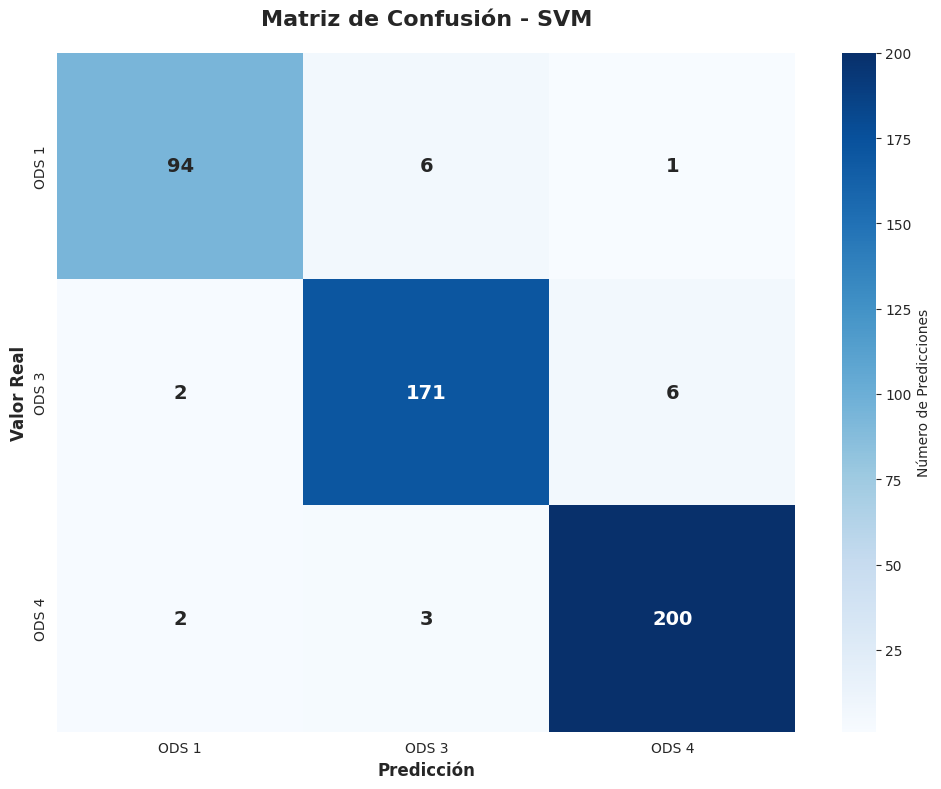


📋 Reporte de clasificación detallado - SVM:
              precision    recall  f1-score   support

       ODS 1       0.96      0.93      0.94       101
       ODS 3       0.95      0.96      0.95       179
       ODS 4       0.97      0.98      0.97       205

    accuracy                           0.96       485
   macro avg       0.96      0.95      0.96       485
weighted avg       0.96      0.96      0.96       485



In [19]:
print(f"📈 Matriz de confusión - {best_model_name}:")
print("=" * 40)

cm = confusion_matrix(y_val, best_model_results["predictions"])

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["ODS 1", "ODS 3", "ODS 4"],
    yticklabels=["ODS 1", "ODS 3", "ODS 4"],
    cbar_kws={"label": "Número de Predicciones"},
    annot_kws={"size": 14, "fontweight": "bold"},
)

plt.title(
    f"Matriz de Confusión - {best_model_name}", fontsize=16, fontweight="bold", pad=20
)
plt.xlabel("Predicción", fontsize=12, fontweight="bold")
plt.ylabel("Valor Real", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

print(f"\n📋 Reporte de clasificación detallado - {best_model_name}:")
print("=" * 60)
print(best_model_results["classification_report"])